In [5]:
%pip install newsapi-python
%pip install --upgrade transformers
%pip install bert-for-sequence-classification
from newsapi import NewsApiClient
import json
import torch
from wordcloud import WordCloud
import pandas as pd
import os
print(torch.__version__)


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
2.4.1+cpu



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


In [6]:

# Function to fetch articles from API or load from local file
def get_articles():
    if os.path.exists('articles.json'):
        # Load from local file if it exists
        with open('articles.json', 'r') as json_file:
            articles = json.load(json_file)
            print("Loaded articles from local file.")
    else:
        # Fetch from API if local file does not exist
        newsapi = NewsApiClient(api_key='cc7b577d5b4b4462b6eef124170903b1')
        articles = newsapi.get_everything(q='Trump OR Harris',
                                          from_param='2024-09-19',
                                          to='2024-10-01',
                                          language='en',
                                          sort_by='relevancy',
                                          page_size=2)
        # Save to local file
        with open('articles.json', 'w') as json_file:
            json.dump(articles, json_file, indent=4)
        print("Articles fetched from API and saved locally.")
    
    return articles

# Call the function to get articles
articles = get_articles()

for article in articles['articles']:
    print(article['content'], article['description'], article['url'])

Loaded articles from local file.
Donald Trump called for the criminal prosecution of Google by the U.S. Justice Department (DOJ) during a flurry of unhinged tweets Friday on his social media platform Truth Social. And in any other p… [+4738 chars] The former president insists Google is hiding positive news stories about him. https://gizmodo.com/trump-says-hell-prosecute-google-if-he-retakes-power-2000504499
Vice President Kamala Harris has accepted a CNN invitation to a presidential debate on 23 October, just days before the November election. 
It is unlikely that her rival Donald Trump will accept the… [+1992 chars] Trump has yet to comment on the proposed rematch, but has said previously he wouldn't debate Harris again. https://www.bbc.com/news/articles/cwyejk91d2qo
On Tuesday night, vice presidential nominees J.D. Vance and Tim Walz will debate one another for the first and only time ahead of the November presidential election.
Before becoming an Ohio senator,… [+1908 chars] Vice pr

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize

nltk.download('vader_lexicon')
nltk.download('punkt')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    words = word_tokenize(text.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word.isalpha()]
    return ' '.join([word for word in words if word not in stop_words])

clean_article = [preprocess(article['content']) for article in articles['articles']]
clean_article += [preprocess(article['description']) for article in articles['articles']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
# Initialize Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Define lists of keywords for Trump and Kamala Harris
trump_keywords = ['trump', 'donald trump', 'president trump']
kamala_keywords = ['kamala', 'kamala harris', 'vice president harris']

def split_sentence_by_candidate(sentence):
    """
    Splits a sentence into parts mentioning Trump and Kamala based on keywords.
    """
    words = word_tokenize(sentence.lower())
    trump_phrases = []
    kamala_phrases = []
    current_phrase = []
    current_candidate = None

    for word in words:
        # Check if the current word refers to Trump
        if word in trump_keywords:
            if current_candidate == "kamala":
                kamala_phrases.append(" ".join(current_phrase))
                current_phrase = []
            current_candidate = "trump"
        
        # Check if the current word refers to Kamala Harris
        elif word in kamala_keywords:
            if current_candidate == "trump":
                trump_phrases.append(" ".join(current_phrase))
                current_phrase = []
            current_candidate = "kamala"
        
        current_phrase.append(word)

    # Append the last phrase
    if current_candidate == "trump":
        trump_phrases.append(" ".join(current_phrase))
    elif current_candidate == "kamala":
        kamala_phrases.append(" ".join(current_phrase))
    
    return trump_phrases, kamala_phrases

def calculate_sentiment_for_candidate_parts(parts):
    """
    Calculate the total sentiment score for a candidate based on their parts of a sentence.
    """
    total_score = 0
    for part in parts:
        sentiment = sid.polarity_scores(part)
        total_score += sentiment['compound']
    return total_score

def calculate_article_sentiment(article):
    # Tokenize article into sentences
    sentences = sent_tokenize(article.lower())
    
    trump_total_score = 0
    kamala_total_score = 0
    
    for sentence in sentences:
        # Split the sentence into parts mentioning Trump and Kamala
        trump_parts, kamala_parts = split_sentence_by_candidate(sentence)
        
        # Calculate sentiment for Trump and Kamala parts separately
        trump_total_score += calculate_sentiment_for_candidate_parts(trump_parts)
        kamala_total_score += calculate_sentiment_for_candidate_parts(kamala_parts)
    
    # Return final combined sentiment
    return trump_total_score, kamala_total_score

# Process each article and calculate the combined score
articles_data =[]
for article in clean_article:
    trump_score, kamala_score = calculate_article_sentiment(article)
    
    # Calculate the final combined score (Trump score - Kamala score)
    combined_score = trump_score - kamala_score
    
    print(f"Article: {article}")
    print(f"Trump Score: {trump_score}, Kamala Harris Score: {kamala_score}")
    print(f"Combined Score (Trump - Kamala): {combined_score}\n")
    articles_data.append({
        'article': article,
        'trump_score': trump_score,
        'kamala_score': kamala_score,
        'combined_score': trump_score - kamala_score  # Calculate the combined score
    })


Article: donald trump called criminal prosecution google justice department doj flurry unhinged tweet friday social medium platform truth social char
Trump Score: -0.2263, Kamala Harris Score: 0
Combined Score (Trump - Kamala): -0.2263

Article: vice president kamala harris ha accepted cnn invitation presidential debate october day november election unlikely rival donald trump accept char
Trump Score: 0.3818, Kamala Harris Score: 0.5423
Combined Score (Trump - Kamala): -0.16050000000000003

Article: tuesday night vice presidential nominee vance tim walz debate one another first time ahead november presidential election becoming ohio senator char
Trump Score: 0, Kamala Harris Score: 0
Combined Score (Trump - Kamala): 0

Article: week ago certain people particular corner internet decided cracked reason kamala harris wa much better donald trump presidential debate char
Trump Score: 0.0, Kamala Harris Score: 0.6124
Combined Score (Trump - Kamala): -0.6124

Article: u kamala harris ha made 

In [16]:

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from nltk.corpus import wordnet as wn
import pandas as pd

nrc = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=["word", "emotion", "association"])
nrc = nrc.pivot(index='word', columns='emotion', values='association').reset_index()

def get_emotions(text):
    words = word_tokenize(text.lower())
    emotions = {emotion: 0 for emotion in nrc.columns[1:]}
    for word in words:
        if word in nrc['word'].values:
            word_emotions = nrc[nrc['word'] == word].iloc[0, 1:]
            for emotion in word_emotions.index:
                emotions[emotion] += word_emotions[emotion]
    return emotions

for article in clean_article:
    emotions = get_emotions(article)
    print(article, emotions)


donald trump called criminal prosecution google justice department doj flurry unhinged tweet friday social medium platform truth social char {'anger': np.int64(1), 'anticipation': np.int64(0), 'disgust': np.int64(2), 'fear': np.int64(1), 'joy': np.int64(0), 'negative': np.int64(2), 'positive': np.int64(2), 'sadness': np.int64(0), 'surprise': np.int64(1), 'trust': np.int64(2)}
vice president kamala harris ha accepted cnn invitation presidential debate october day november election unlikely rival donald trump accept char {'anger': np.int64(0), 'anticipation': np.int64(1), 'disgust': np.int64(0), 'fear': np.int64(0), 'joy': np.int64(0), 'negative': np.int64(1), 'positive': np.int64(3), 'sadness': np.int64(0), 'surprise': np.int64(1), 'trust': np.int64(1)}
tuesday night vice presidential nominee vance tim walz debate one another first time ahead november presidential election becoming ohio senator char {'anger': np.int64(0), 'anticipation': np.int64(1), 'disgust': np.int64(0), 'fear': np.i

influencers think democrat literally steer hurricane region {'anger': np.int64(0), 'anticipation': np.int64(0), 'disgust': np.int64(0), 'fear': np.int64(1), 'joy': np.int64(0), 'negative': np.int64(1), 'positive': np.int64(0), 'sadness': np.int64(0), 'surprise': np.int64(0), 'trust': np.int64(0)}
harris spending pennsylvania fueled huge fundraising number wall street event sunday raised million {'anger': np.int64(0), 'anticipation': np.int64(0), 'disgust': np.int64(0), 'fear': np.int64(0), 'joy': np.int64(0), 'negative': np.int64(0), 'positive': np.int64(0), 'sadness': np.int64(0), 'surprise': np.int64(0), 'trust': np.int64(0)}
kamala harris donald trump extremely close race one key metric harris showing sign momentum {'anger': np.int64(0), 'anticipation': np.int64(1), 'disgust': np.int64(0), 'fear': np.int64(0), 'joy': np.int64(0), 'negative': np.int64(0), 'positive': np.int64(1), 'sadness': np.int64(0), 'surprise': np.int64(1), 'trust': np.int64(0)}
voter dissatisfied trump harris co

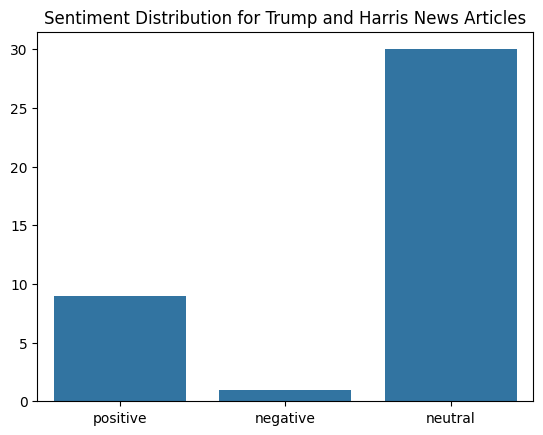

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiments = ['positive', 'negative', 'neutral']
counts = [len([s for s in clean_article if sid.polarity_scores(s)['compound'] > 0.5]),
          len([s for s in clean_article if sid.polarity_scores(s)['compound'] < -0.5]),
          len([s for s in clean_article if -0.5 <= sid.polarity_scores(s)['compound'] <= 0.5])]

sns.barplot(x=sentiments, y=counts)
plt.title('Sentiment Distribution for Trump and Harris News Articles')
plt.show()


                                             article  trump_score  \
0  donald trump called criminal prosecution googl...      -0.2263   
1  vice president kamala harris ha accepted cnn i...       0.3818   
2  tuesday night vice presidential nominee vance ...       0.0000   
3  week ago certain people particular corner inte...       0.0000   
4  u kamala harris ha made rare trip border seek ...       0.0000   

   kamala_score  combined_score  
0        0.0000         -0.2263  
1        0.5423         -0.1605  
2        0.0000          0.0000  
3        0.6124         -0.6124  
4       -0.4404          0.4404  
       trump_score  kamala_score  combined_score
count    40.000000     40.000000       40.000000
mean      0.031205      0.035902       -0.004698
std       0.268028      0.165861        0.301710
min      -0.891000     -0.440400       -0.891000
25%       0.000000      0.000000       -0.032000
50%       0.000000      0.000000        0.000000
75%       0.000000      0.000000      

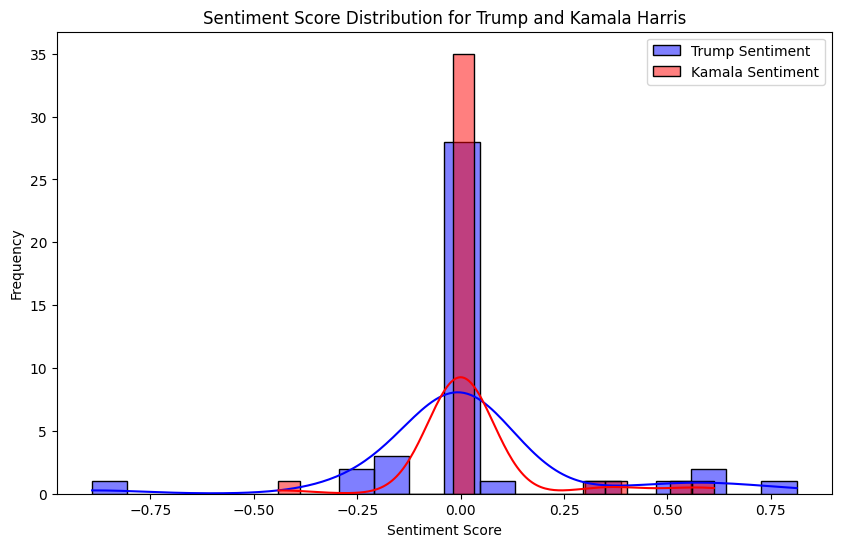

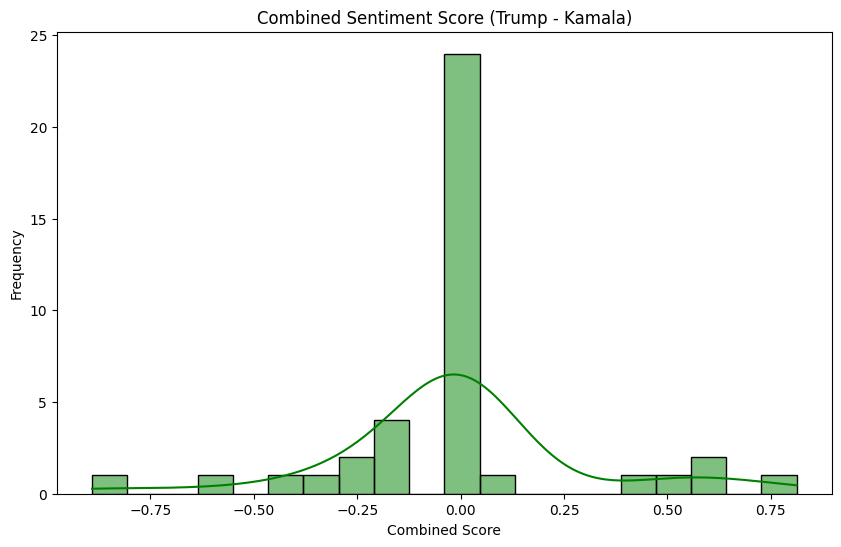

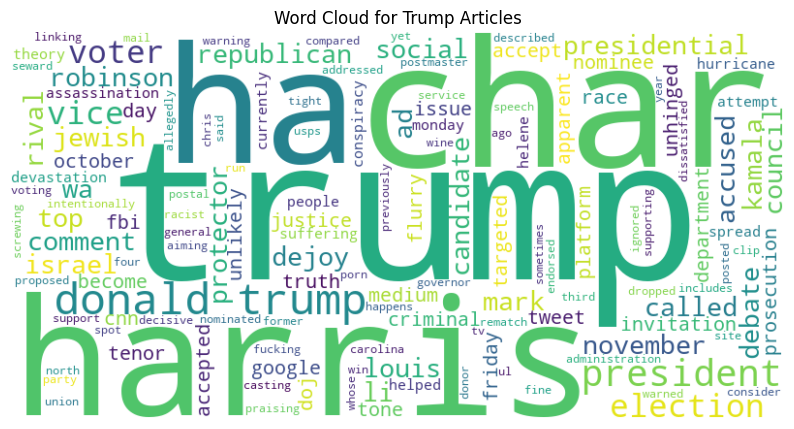

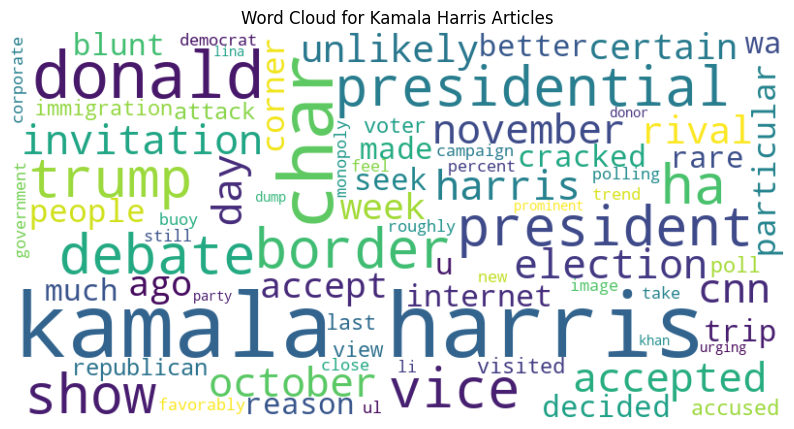

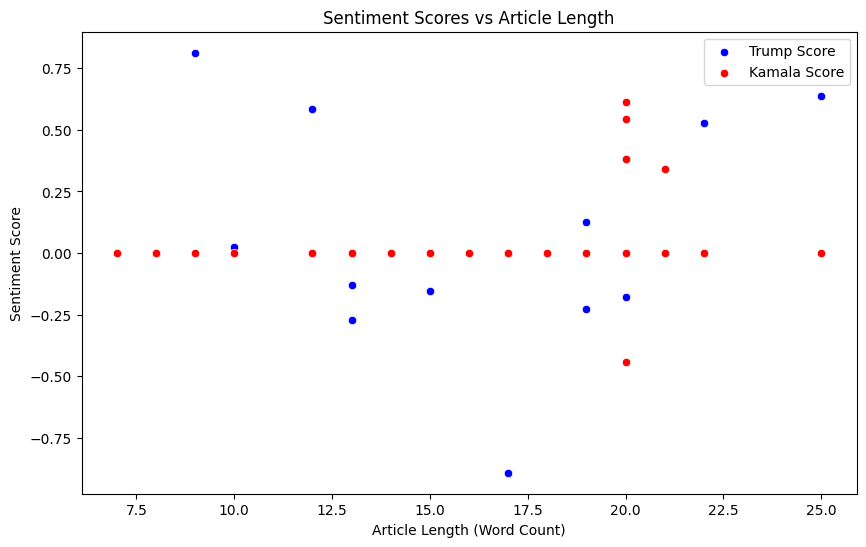

Most positive article for Trump: harris trump aiming win union whose support decisive november
Most negative article for Trump: donald trump helped spread conspiracy theory monday people currently suffering devastation hurricane helene intentionally ignored republican char
Most positive article for Kamala: week ago certain people particular corner internet decided cracked reason kamala harris wa much better donald trump presidential debate char
Most negative article for Kamala: u kamala harris ha made rare trip border seek blunt republican attack immigration harris last visited border accused donald char


In [ ]:
# Convert the data into a DataFrame
df = pd.DataFrame(articles_data)

# Add a 'combined_score' column (Trump - Kamala)
df['combined_score'] = df['trump_score'] - df['kamala_score']

# Display the DataFrame to inspect the structure
print(df.head())

# Summary statistics for sentiment scores
print(df.describe())

# Count the number of articles
print(f"Total number of articles: {len(df)}")

# Count articles favoring Trump (combined_score > 0) vs Kamala (combined_score < 0)
trump_favored = (df['combined_score'] > 0).sum()
kamala_favored = (df['combined_score'] < 0).sum()
print(f"Articles favoring Trump: {trump_favored}")
print(f"Articles favoring Kamala: {kamala_favored}")

# Distribution of Trump and Kamala sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['trump_score'], color='blue', label='Trump Sentiment', kde=True, bins=20)
sns.histplot(df['kamala_score'], color='red', label='Kamala Sentiment', kde=True, bins=20)
plt.title('Sentiment Score Distribution for Trump and Kamala Harris')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Combined sentiment score (Trump - Kamala)
plt.figure(figsize=(10, 6))
sns.histplot(df['combined_score'], color='green', kde=True, bins=20)
plt.title('Combined Sentiment Score (Trump - Kamala)')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.show()

# Function to create word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create word clouds for Trump and Kamala mentions
trump_articles = " ".join(df[df['trump_score'] != 0]['article'])
kamala_articles = " ".join(df[df['kamala_score'] != 0]['article'])

plot_wordcloud(trump_articles, "Word Cloud for Trump Articles")
plot_wordcloud(kamala_articles, "Word Cloud for Kamala Harris Articles")


# Add an 'article_length' column (number of words in each article)
df['article_length'] = df['article'].apply(lambda x: len(x.split()))

# Plot sentiment scores vs article length
plt.figure(figsize=(10, 6))
sns.scatterplot(x='article_length', y='trump_score', data=df, label='Trump Score', color='blue')
sns.scatterplot(x='article_length', y='kamala_score', data=df, label='Kamala Score', color='red')
plt.title('Sentiment Scores vs Article Length')
plt.xlabel('Article Length (Word Count)')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()


most_positive_trump = df.loc[df['trump_score'].idxmax()]['article']
most_negative_trump = df.loc[df['trump_score'].idxmin()]['article']
most_positive_kamala = df.loc[df['kamala_score'].idxmax()]['article']
most_negative_kamala = df.loc[df['kamala_score'].idxmin()]['article']

print(f"Most positive article for Trump: {most_positive_trump}")
print(f"Most negative article for Trump: {most_negative_trump}")
print(f"Most positive article for Kamala: {most_positive_kamala}")
print(f"Most negative article for Kamala: {most_negative_kamala}")
